# 学校の Class 編成（再定義）

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import pulp

In [9]:
s_df = pd.read_csv('students.csv')
s_pair_df = pd.read_csv('student_pairs.csv')

In [10]:
prob = pulp.LpProblem('ClassAssignmentProblem', pulp.LpMaximize)

In [11]:
# 生徒の List
S = s_df['student_id'].tolist()

# Class の List
C = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']

# 生徒と Class の Pair の List
SC = [(s, c) for s in S for c in C]

In [12]:
# 生徒をどの Class に割り当てるを変数として定義
x = pulp.LpVariable.dicts('x', SC, cat='Binary')

In [13]:
# 1). 各生徒は１つの Class に割り当てる
for s in S:
    prob += pulp.lpSum([x[s, c] for c in C]) == 1

In [14]:
# 2). 各 Class の生徒の人数は 39人以上、40人以下とする
for c in C:
    prob += pulp.lpSum([x[s, c] for s in S]) >= 39
    prob += pulp.lpSum([x[s, c]] for s in S) <= 40

In [15]:
# 男子生徒の List
S_male = [row.student_id for row in s_df.itertuples() if row.gender == 1]

# 女子生徒の List
S_female = [row.student_id for row in s_df.itertuples() if row.gender == 0]

In [16]:
# 3). 各 Class の男子生徒、女子生徒の人数は 20人以下とする
for c in C:
    prob += pulp.lpSum([x[s, c] for s in S_male]) <= 20
    prob += pulp.lpSum([x[s, c] for s in S_female]) <= 20

In [17]:
# 学力を辞書表現に変換
score = {row.student_id: row.score for row in s_df.itertuples()}

# 平均点の算出
score_mean = s_df['score'].mean()

In [18]:
# 4). 各 Class の学力試験の平均点は学年平均点±10点とする
for c in C:
    prob += pulp.lpSum([x[s, c] * score[s] for s in S]) >= (score_mean - 10) * pulp.lpSum([x[s, c] for s in S])
    prob += pulp.lpSum([x[s, c] * score[s] for s in S]) <= (score_mean + 10) * pulp.lpSum([x[s, c] for s in S])

In [19]:
# Leader 気質の生徒の集合
S_leader = [row.student_id for row in s_df.itertuples() if row.leader_flag == 1]

In [20]:
# 5). 各 Class に Leader 気質の生徒を２人以上割り当てる
for c in C:
    prob += pulp.lpSum([x[s, c] for s in S_leader]) >= 2

In [21]:
# 特別な支援が必要な生徒の集合
S_support = [row.student_id for row in s_df.itertuples() if row.support_flag == 1]

In [22]:
# 6). 特別な支援が必要な生徒は各 Class に１人以下とする
for c in C:
    prob += pulp.lpSum([x[s, c] for s in S_support]) <= 1

In [23]:
# 生徒の特定 Pair list
SS = [(row.student_id1, row.student_id2) for row in s_pair_df.itertuples()]

In [24]:
# 7). 特定 Pair の生徒は同一 Class に割り当てない
for row in s_pair_df.itertuples():
    s1 = row.student_id1
    s2 = row.student_id2
    for c in C:
        prob += x[s, c] + x[s2, c] <= 1

In [25]:
# 初期 Class 編成を作成
s_df['score_rank'] = s_df['score'].rank(ascending=False, method='first')
class_dic = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H'}
s_df['init_assigned_class'] = s_df['score_rank'].map(lambda x: x % 8).map(class_dic)
init_flag = {(s, c): 0 for s in S for c in C}
for row in s_df.itertuples():
    init_flag[row.student_id, row.init_assigned_class] = 1

In [26]:
# 目的関数: 初期 Class 編成とできるだけ一致させる
prob += pulp.lpSum([x[s, c] * init_flag[s, c] for s, c in SC])

In [27]:
# 求解
status = prob.solve()
print(f'status: {pulp.LpStatus[status]}')

status: Optimal


In [28]:
# 最適化結果の表示
# 各 Class に割り当てられている生徒の List を辞書に格納
C2Ss = {}
for c in C:
    C2Ss[c] = [s for s in S if x[s, c].value() == 1]

for c, Ss in C2Ss.items():
    print(f'Class: {c}')
    print(f'Num: {len(Ss)}')
    print(f'Student: {Ss}')
    print()

Class: A
Num: 39
Student: [23, 56, 68, 82, 89, 94, 102, 113, 115, 117, 123, 124, 127, 140, 147, 172, 173, 185, 186, 204, 210, 228, 255, 259, 273, 274, 277, 280, 285, 288, 289, 292, 295, 297, 304, 308, 311, 313, 316]

Class: B
Num: 40
Student: [14, 30, 32, 35, 41, 49, 63, 64, 66, 79, 83, 86, 88, 97, 114, 119, 122, 132, 134, 141, 149, 151, 158, 165, 169, 178, 190, 198, 200, 209, 213, 216, 226, 237, 245, 272, 296, 303, 306, 307]

Class: C
Num: 40
Student: [21, 38, 44, 46, 51, 54, 62, 73, 75, 76, 84, 85, 99, 120, 138, 142, 143, 144, 150, 166, 183, 184, 192, 193, 195, 201, 205, 207, 211, 212, 217, 221, 222, 243, 244, 263, 264, 287, 299, 315]

Class: D
Num: 40
Student: [5, 11, 17, 24, 39, 47, 50, 61, 67, 74, 90, 92, 93, 100, 106, 109, 116, 131, 136, 152, 155, 167, 170, 176, 177, 196, 199, 214, 218, 219, 227, 230, 231, 236, 239, 253, 257, 271, 294, 309]

Class: E
Num: 39
Student: [4, 8, 12, 13, 19, 22, 27, 33, 43, 48, 55, 57, 59, 98, 104, 112, 121, 125, 130, 133, 137, 139, 153, 180, 189, 203,

各 Class の学力の分布が偏っていないか検証。

In [29]:
# 検証用の DataFrame の用意
result_df2 = s_df.copy()

# 各生徒がどの Class に割り当てられたかの情報を辞書に格納
S2C = {s: c for s in S for c in C if x[s, c].value() == 1}

# 生徒 Data に各生徒がどの Class に割り当てられたかの情報を結合
result_df2['assigned_class'] = result_df2['student_id'].map(S2C)
result_df2.head(5)

,student_id,gender,leader_flag,support_flag,score,score_rank,init_assigned_class,assigned_class
0,1,0,0,0,335,109.0,F,F
1,2,1,0,0,379,38.0,G,G
2,3,0,0,0,350,79.0,H,H
3,4,0,0,0,301,172.0,E,E
4,5,1,0,0,317,147.0,D,D


各 Class の学力の分布を可視化

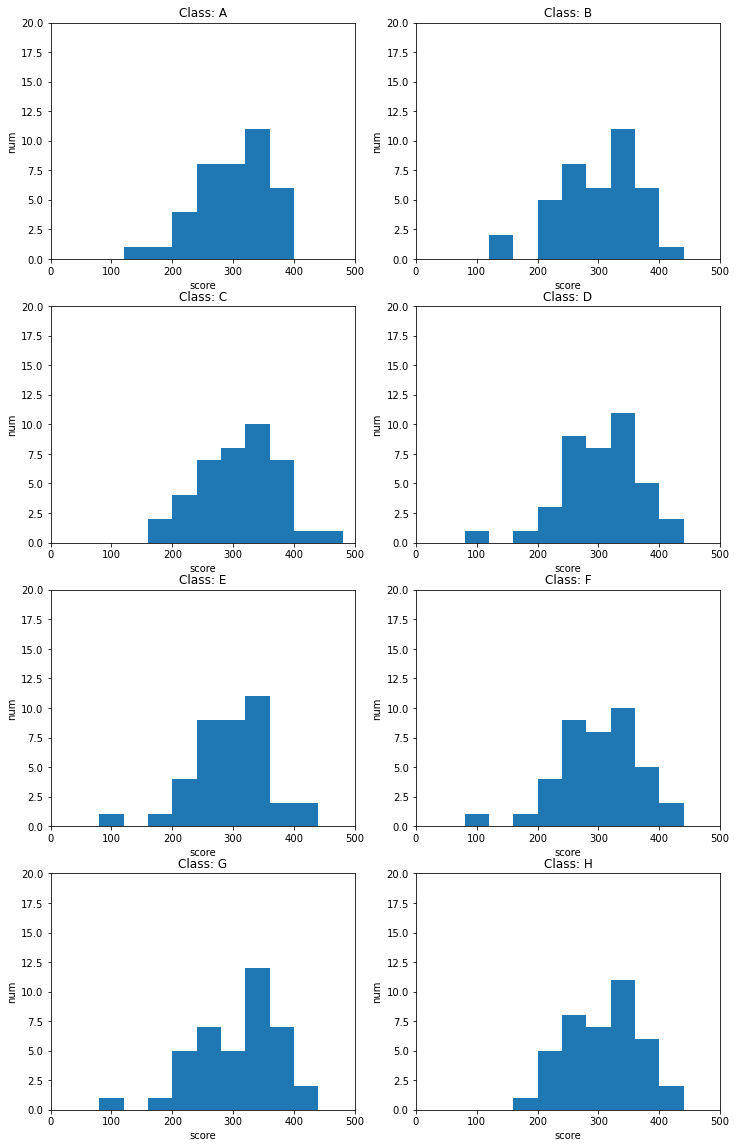

In [32]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 20))
for i, c in enumerate(C):
    cls_df = result_df2[result_df2['assigned_class'] == c]
    ax = fig.add_subplot(4,
                         2,
                         i + 1,
                         xlabel='score',
                         ylabel='num',
                         xlim=(0, 500),
                         ylim=(0, 20),
                         title=f'Class: {c:s}')
    ax.hist(cls_df['score'], bins=range(0, 500, 40))